# Baseline model based on anatomy features

Useful links :

- https://brainder.org/2018/01/23/how-do-we-measure-thickness-area-and-volume-of-the-cerebral-cortex/
- https://s3.us-east-2.amazonaws.com/brainder/publications/2010/winkler2010_thickness_area.pdf
    - The results suggest that surface area and cortical thickness measurements should be considered separately and preferred over gray matter volumes for imaging genetic studies.

In [1]:
path = ".."

import sys
sys.path.insert(0, path)

In [2]:
import warnings
warnings.filterwarnings('ignore')

    
import numpy as np
import pandas as pd
import pandas_profiling

import matplotlib.pylab as plt
%matplotlib inline

import seaborn as sns

In [3]:
from problem import get_train_data, get_test_data

data_train_, labels_train_ = get_train_data(path=path)
data_test_, labels_test_ = get_test_data(path=path)

## Preprocess input data

Join train and test

In [4]:
data_train = pd.concat([data_train_, pd.Series(labels_train_, index=data_train_.index, name='target')], axis=1)
data_test = pd.concat([data_test_, pd.Series(labels_test_, index=data_test_.index, name='target')], axis=1)

data_train.loc[:, 'is_train'] = 1
data_test.loc[:, 'is_train'] = 0

data = pd.concat([data_train, data_test], axis=0)

In [5]:
data['participants_sex'] = data['participants_sex'].map({'F': -1.0, 'M': +1.0}) 
accepted_anatomy = data['anatomy_select'].isin([1, 2])

In [6]:
data.shape

(1150, 222)

Remove poor QA data

In [7]:
data1 = data[accepted_anatomy].copy()
data1.shape

(1031, 222)

In [8]:
import re 

left_cols = sorted([col for col in data1.columns if col.startswith('anatomy') and re.match(r".+(lh|Left)", col)])

left_cols.remove('anatomy_Left-WM-hypointensities')
left_cols.remove('anatomy_Left-non-WM-hypointensities')

right_cols = []
for c in left_cols:
    if "lh" in c:
        c = c.replace("lh", "rh")
    elif "Left" in c:
        c = c.replace("Left", "Right")
    right_cols.append(c)

anatomy_LR_diff_cols = [(c1, c2) for c1, c2 in zip(left_cols, right_cols)]

In [9]:
to_remove_anatomy_features = [
    'anatomy_Left-WM-hypointensities',
    'anatomy_Left-non-WM-hypointensities',
    'anatomy_Right-WM-hypointensities',
    'anatomy_Right-non-WM-hypointensities',
    'anatomy_5th-Ventricle', 
    'anatomy_non-WM-hypointensities',
    
    # Correlated with others
    'anatomy_EstimatedTotalIntraCranialVol',
    'anatomy_SupraTentorialVolNotVentVox',
#     'anatomy_SubCortGrayVol',
#     'anatomy_TotalGrayVol',
    
    # Remove correlated L <-> R
    'anatomy_Right-Caudate',
    'anatomy_Right-Cerebellum-Cortex',
    'anatomy_Right-Putamen',
    'anatomy_Right-VentralDC',
    'anatomy_rhCerebralWhiteMatterVol',
    'anatomy_rhCortexVol',
    'anatomy_rhSurfaceHoles',
    'anatomy_rh_MeanThickness_thickness',
    'anatomy_rh_WhiteSurfArea_area',
    'anatomy_rh_superiorparietal_thickness',
]

volume_cols = sorted([col for col in data1.columns if col.startswith('anatomy') and re.match(r".+(Vol)", col)])
to_remove_anatomy_features += volume_cols
to_remove_anatomy_features = list(set(to_remove_anatomy_features))


In [10]:
anatomy_cols = [col for col in data1.columns if col.startswith('anatomy')]

anatomy_cols.remove('anatomy_select')

for c in to_remove_anatomy_features:
    anatomy_cols.remove(c)

participant_cols = [col for col in data1.columns if col.startswith('participant')]
participant_cols.remove('participants_site')

In [11]:
len(anatomy_cols)

175

In [12]:
anatomy_diff_cols = []
to_remove_anatomy_diff_cols = [
    'anatomy_lh_WhiteSurfArea_area'
]


for c1, c2 in anatomy_LR_diff_cols:
    data1.loc[:, "({} - {})".format(c1, c2)] = data1[c1] - data1[c2]
    anatomy_diff_cols.append("({} - {})".format(c1, c2))
#     if c2 in anatomy_cols:
#         to_remove_anatomy_diff_cols.append(c2)


for c in to_remove_anatomy_diff_cols:
    try:
        anatomy_cols.remove(c)
    except Exception as e:
        print(e, c)
    

In [13]:
len(anatomy_diff_cols)

87

In [14]:
data1.shape

(1031, 309)

Rescale features:

- age -> age / 100 in [0.0, 1.0]

In [15]:
data1.loc[:, 'participants_age'] = data1['participants_age'] / 100.0

Select only area or thickness

In [16]:
anatomy_cols = sorted([col for col in anatomy_cols if re.match(r".+(area|thickness)", col)])
len(anatomy_cols)


138

In [17]:
anatomy_diff_cols = sorted([col for col in anatomy_diff_cols if re.match(r".+(area|thickness)", col)])
len(anatomy_diff_cols)

71

Compute inversions

In [18]:
inverted_cols = []

for c in anatomy_cols + anatomy_diff_cols + ["participants_age", ]:
    data1.loc[:, "1/({})".format(c)] = 1.0 / (data1[c] + 1e-10)
    inverted_cols.append("1/({})".format(c))

In [19]:
data1.head()

,participants_site,participants_sex,participants_age,anatomy_lh_bankssts_area,anatomy_lh_caudalanteriorcingulate_area,anatomy_lh_caudalmiddlefrontal_area,anatomy_lh_cuneus_area,anatomy_lh_entorhinal_area,anatomy_lh_fusiform_area,anatomy_lh_inferiorparietal_area,...,1/((anatomy_lh_superiorparietal_thickness - anatomy_rh_superiorparietal_thickness)),1/((anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area)),1/((anatomy_lh_superiortemporal_thickness - anatomy_rh_superiortemporal_thickness)),1/((anatomy_lh_supramarginal_area - anatomy_rh_supramarginal_area)),1/((anatomy_lh_supramarginal_thickness - anatomy_rh_supramarginal_thickness)),1/((anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)),1/((anatomy_lh_temporalpole_thickness - anatomy_rh_temporalpole_thickness)),1/((anatomy_lh_transversetemporal_area - anatomy_rh_transversetemporal_area)),1/((anatomy_lh_transversetemporal_thickness - anatomy_rh_transversetemporal_thickness)),1/(participants_age)
subject_id,,,,,,,,,,,,,,,,,,,,,
1932355398536124106,5,-1.0,0.093014,977.0,427.0,1884.0,1449.0,463.0,2790.0,4091.0,...,15.384615,-0.010753,166.666664,-0.011494,-13.333333,-0.028571,10.989011,0.010000,5.128205,10.751105
5174041730092253771,19,1.0,0.290000,1279.0,730.0,2419.0,1611.0,467.0,3562.0,5380.0,...,-28.571429,0.001953,-35.714286,0.001361,-25.000000,-0.014085,4.201681,0.006711,5.882353,3.448276
10219322676643534800,19,-1.0,0.450000,926.0,446.0,1897.0,2135.0,570.0,3064.0,4834.0,...,13.333333,0.003922,-83.333334,0.001842,18.867924,-0.037037,-29.411765,0.008000,-33.333333,2.222222
10645466564919190227,5,-1.0,0.092164,983.0,588.0,2479.0,1312.0,525.0,3766.0,5091.0,...,199.999996,0.001859,-18.181818,0.001458,-3.571429,0.142857,2.680965,0.008475,-13.513514,10.850178
14512541342641936232,28,1.0,0.150500,1488.0,593.0,2309.0,1829.0,726.0,3720.0,5432.0,...,7.462687,0.002257,-9.345794,0.004274,27.027027,0.142857,8.264463,0.005319,-3.448276,6.644518


In [20]:
data1.shape

(1031, 519)

Polynomial 2nd degree



In [22]:
train_columns1 = anatomy_cols + anatomy_diff_cols + ['participants_age', ]
train_columns2 = inverted_cols
train_columns = train_columns1 + train_columns2
len(train_columns1), len(train_columns2)

(210, 210)

In [23]:
data_ = data1[train_columns].values
data_.shape

(1031, 420)

In [24]:
pairs_columns = []

n1 = len(train_columns1) * (len(train_columns1) - 1) // 2
n2 = (len(train_columns1) - 1) * len(train_columns2)

pairs_data = np.zeros((len(data_), n1 + n2))
offset = len(train_columns1)

c = 0
for i, f1 in enumerate(train_columns1):
    for j, f2 in enumerate(train_columns1):
        if i < j:
            pairs_columns.append("{} x {}".format(f1, f2))
            pairs_data[:, c] = data_[:, i] * data_[:, j]
            c += 1


    for j, f2 in enumerate(train_columns2):
        if i != j:
            pairs_columns.append("{} x {}".format(f1, f2))
            pairs_data[:, c] = data_[:, i] * data_[:, offset + j]
            c += 1            

In [25]:
pairs_df = pd.DataFrame(pairs_data, columns=pairs_columns, index=data1.index)

In [26]:
pairs_columns = pairs_df.columns.values.tolist()
pairs_df.shape

(1031, 65835)

In [27]:
data2 = pd.concat([data1, pairs_df], axis=1)

In [28]:
data2.shape

(1031, 66354)

In [29]:
train_columns = anatomy_cols + anatomy_diff_cols + participant_cols + inverted_cols + pairs_columns
len(train_columns)

66256

### Feature extraction and filtering

Compute correlations with target

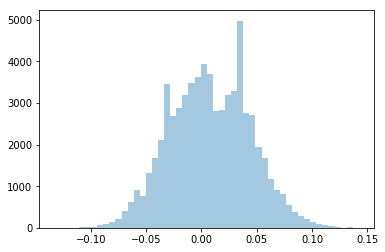

In [31]:
corr12_inv = [
    data2[c].corr(data2['target']) for c in train_columns
]

sns.distplot(corr12_inv, kde=False)

In [32]:
corr12_inv_ = pd.Series(corr12_inv, index=train_columns)

In [33]:
corr12_inv_[corr12_inv_ > 0.11].sort_values()

anatomy_lh_lateralorbitofrontal_thickness x anatomy_rh_precuneus_area                0.110335
anatomy_lh_entorhinal_thickness x anatomy_rh_lateraloccipital_area                   0.110348
anatomy_lh_parsorbitalis_area x anatomy_rh_entorhinal_thickness                      0.110398
anatomy_lh_MeanThickness_thickness x anatomy_rh_frontalpole_area                     0.110402
anatomy_rh_precuneus_area x anatomy_rh_temporalpole_thickness                        0.110435
anatomy_lh_superiorfrontal_thickness x 1/(anatomy_rh_precentral_thickness)           0.110529
anatomy_rh_lateraloccipital_area x anatomy_rh_superiortemporal_thickness             0.111005
anatomy_lh_inferiortemporal_thickness x anatomy_rh_precuneus_area                    0.111102
anatomy_lh_parsorbitalis_area x anatomy_rh_frontalpole_area                          0.111111
anatomy_lh_superiorfrontal_area x anatomy_rh_precuneus_area                          0.111231
anatomy_lh_superiorfrontal_area x anatomy_rh_lateraloccipita

Filter duplicates and highly correlated features

In [49]:
# corr12_inv_approx = corr12_inv_.apply(lambda x: round(x, 4))
corr12_inv_approx = corr12_inv_

filtered_corr12_inv_ = corr12_inv_approx[~corr12_inv_approx.duplicated()]
filtered_corr12_inv_ = filtered_corr12_inv_[filtered_corr12_inv_.abs() > 0.027]

In [50]:
filtered_corr12_inv_.shape, corr12_inv_.shape

((34338,), (66256,))

In [51]:
np.min(filtered_corr12_inv_), np.max(filtered_corr12_inv_)

(-0.1326064191239223, 0.1422520929724115)

In [52]:
filtered_corr12_inv_[filtered_corr12_inv_ > 0.14].sort_values()

participants_sex                                                 0.140615
anatomy_rh_entorhinal_thickness x anatomy_rh_frontalpole_area    0.142252
dtype: float64

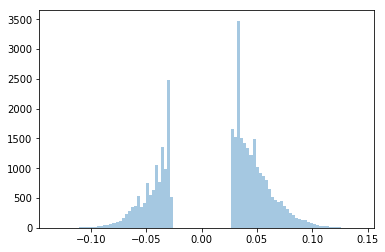

In [53]:
sns.distplot(filtered_corr12_inv_, kde=False, bins=100)

In [61]:
corr_selected_columns = filtered_corr12_inv_.index.values.tolist()
corr_selected_columns[-10:], len(corr_selected_columns)

(['participants_age x 1/((anatomy_lh_rostralanteriorcingulate_area - anatomy_rh_rostralanteriorcingulate_area))',
  'participants_age x 1/((anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area))',
  'participants_age x 1/((anatomy_lh_superiorfrontal_area - anatomy_rh_superiorfrontal_area))',
  'participants_age x 1/((anatomy_lh_superiorparietal_area - anatomy_rh_superiorparietal_area))',
  'participants_age x 1/((anatomy_lh_superiorparietal_thickness - anatomy_rh_superiorparietal_thickness))',
  'participants_age x 1/((anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area))',
  'participants_age x 1/((anatomy_lh_superiortemporal_thickness - anatomy_rh_superiortemporal_thickness))',
  'participants_age x 1/((anatomy_lh_supramarginal_area - anatomy_rh_supramarginal_area))',
  'participants_age x 1/((anatomy_lh_transversetemporal_area - anatomy_rh_transversetemporal_area))',
  'participants_age x 1/((anatomy_lh_transversetemporal_thickness - anatomy_rh

In [55]:
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

n_jobs=1
seed = 42


class FeatureExtractor(BaseEstimator, TransformerMixin):
        
    def fit(self, X_df, y):
        return self

    def transform(self, X_df):
        # get only the anatomical information
        return X_df
        

class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = make_pipeline(StandardScaler(), 
                                 LogisticRegression(random_state=seed))

    def fit(self, X, y):
        self.clf.fit(X, y)
        return self
        
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)


In [56]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, StratifiedShuffleSplit


def evaluation(X, y):
    pipe = make_pipeline(FeatureExtractor(), Classifier())
    cv = StratifiedShuffleSplit(n_splits=10, test_size=0.5, random_state=42).split(X, y)
    results = cross_validate(pipe, X, y, scoring=['roc_auc', 'accuracy'], cv=cv,
                             verbose=1, return_train_score=True,
                             n_jobs=1)
    
    return results


from problem import get_cv


def original_evaluation(X, y):
    pipe = make_pipeline(FeatureExtractor(), Classifier())
    cv = get_cv(X, y)
    results = cross_validate(pipe, X, y, scoring=['roc_auc', 'accuracy'], cv=cv,
                             verbose=1, return_train_score=True,
                             n_jobs=1)    
    return results

Check `corr_selected_columns`

In [57]:
import numpy as np

results = evaluation(data2[corr_selected_columns], data2['target'])

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.626 +- 0.029 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.596 +- 0.025


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  2.3min finished


```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.633 +- 0.015 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.601 +- 0.009
```




with vol
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.683 +- 0.030 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.633 +- 0.025
```

In [58]:
def visualize_coefficients(classifier, feature_names, n_top_features=25):
    # get coefficients with large absolute values 
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    # plot them
    plt.figure(figsize=(20, 10))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    if feature_names is not None:
        feature_names = np.array(feature_names)
        plt.xticks(np.arange(1, 1 + 2 * n_top_features), feature_names[interesting_coefficients], rotation=60, ha="right");

In [59]:
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

n_jobs=1
seed = 42


class FeatureExtractor(BaseEstimator, TransformerMixin):
        
    def fit(self, X_df, y):
        return self

    def transform(self, X_df):
        # get only the anatomical information
        return X_df
        

class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = make_pipeline(StandardScaler(), 
                                 LogisticRegression(random_state=seed))

    def fit(self, X, y):
        self.clf.fit(X, y)
        return self
        
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)


### Feature importance of Corr selected features

In [62]:
pipe = make_pipeline(FeatureExtractor(), Classifier())
pipe.fit(data2[corr_selected_columns], data2['target'])

Pipeline(memory=None,
     steps=[('featureextractor', FeatureExtractor()), ('classifier', Classifier())])

In [63]:
log_reg2 = pipe.named_steps['classifier'].clf.named_steps['logisticregression']

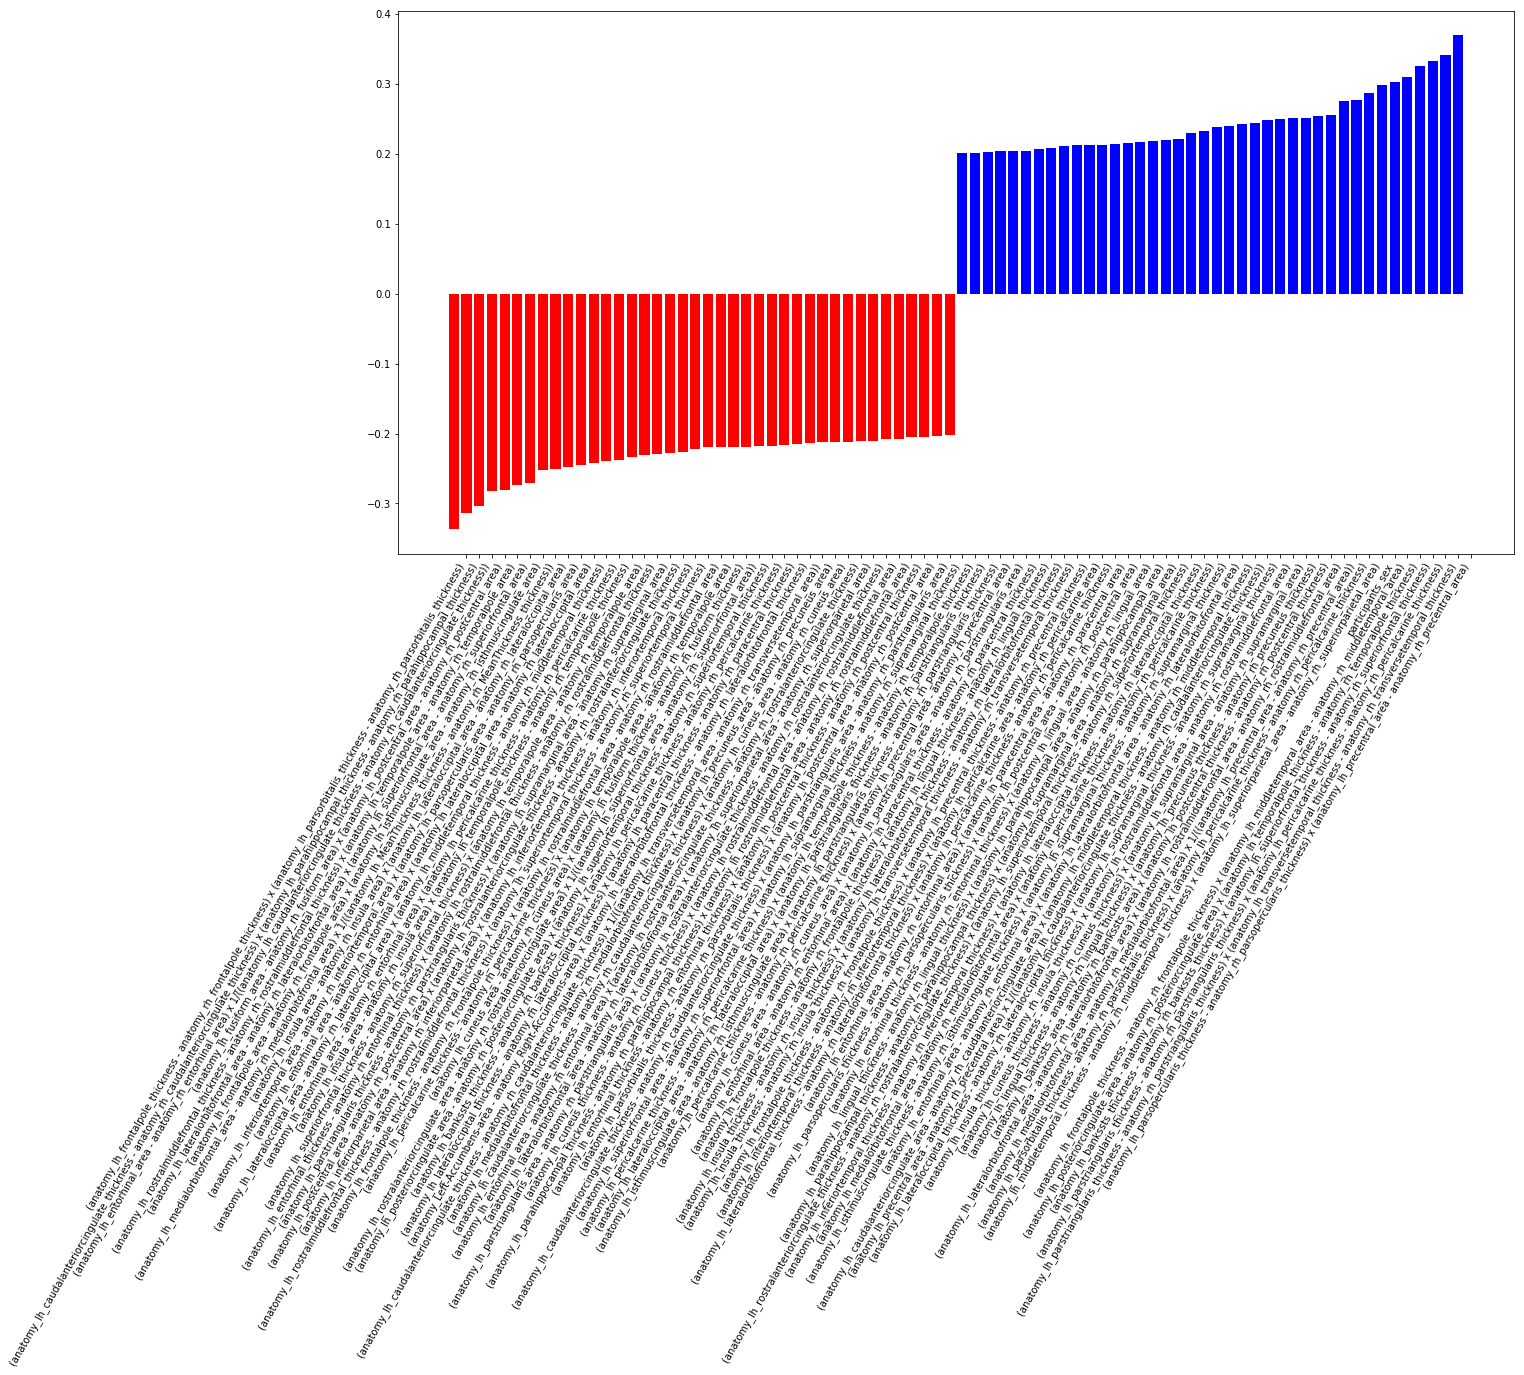

In [64]:
visualize_coefficients(log_reg2, feature_names=corr_selected_columns, n_top_features=40)

In [65]:
coef2 = log_reg2.coef_.ravel()

In [66]:
coef2.min(), coef2.max(), np.abs(coef2).min()

(-0.33718546807613675, 0.3696359265336894, 1.3579414739656355e-07)

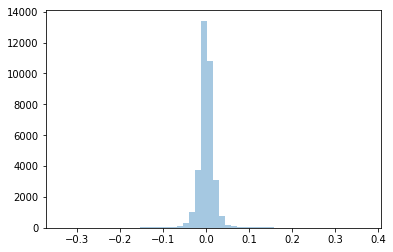

In [67]:
sns.distplot(coef2, kde=False)

In [108]:
neg_threshold = 0.35 * coef2.min()
pos_threshold = 0.35 * coef2.max()
neg_threshold, pos_threshold 

(-0.11801491382664786, 0.12937257428679128)

In [109]:
positive_coefficients = np.where(coef2 > pos_threshold)[0]
negative_coefficients = np.where(coef2 < neg_threshold)[0]

In [110]:
len(positive_coefficients), len(negative_coefficients)

(144, 155)

In [111]:
# n_top_features = 400
# positive_coefficients = positive_coefficients_2[-n_top_features:]
# negative_coefficients = negative_coefficients_2[:n_top_features]

interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
top_corr_selected_columns = np.array(corr_selected_columns)[interesting_coefficients].tolist()

In [112]:
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import StratifiedKFold

seed = 90
        

class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = None

    def fit(self, X, y):
        
        pipe_cv = make_pipeline(StandardScaler(), 
                                LogisticRegressionCV(n_jobs=8,
                                                     # cv=StratifiedKFold(n_splits=5, random_state=seed),
                                                     scoring="roc_auc", 
                                                     random_state=seed))
        pipe_cv.fit(X, y)
        best_C = pipe_cv.named_steps['logisticregressioncv'].C_[0]
        self.clf = make_pipeline(StandardScaler(), LogisticRegression(C=best_C, random_state=seed))
        self.clf.fit(X, y)
        return self
        
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)

In [113]:
results = evaluation(data2[top_corr_selected_columns], data2['target'])

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 0.969 +- 0.027
Validation score ROC-AUC: 0.751 +- 0.018 

Training score accuracy: 0.911 +- 0.045
Validation score accuracy: 0.692 +- 0.023


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.2s finished




**config 1**

```
anatomy select < 2
corr12_inv_approx = corr12_inv_.apply(lambda x: round(x, 5))

filtered_corr12_inv_ = corr12_inv_approx[~corr12_inv_approx.duplicated()]
filtered_corr12_inv_ = filtered_corr12_inv_[filtered_corr12_inv_.abs() > 0.03]
```

(-0.08605396730502125, 0.07733905985162687)
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.765 +- 0.009 

Training score accuracy: 0.999 +- 0.002
Validation score accuracy: 0.697 +- 0.010
```

In [123]:
results = original_evaluation(data2[top_corr_selected_columns], data2['target'])

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.844 +- 0.023 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.763 +- 0.030


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   11.1s finished




**config 2**
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.844 +- 0.023 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.763 +- 0.030
```



**config 1**
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.842 +- 0.024 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.762 +- 0.022
```

Try SVM

In [167]:
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

seed = 90
        

class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = None

    def fit(self, X, y):
                
        params = {
            "C": np.logspace(-2, 5, num=12),
            "kernel": ["rbf", "linear"]
        }
        clf = SVC()
        pipe_cv = make_pipeline(StandardScaler(), 
                                GridSearchCV(clf, params, 
                                             n_jobs=8, 
                                             cv=StratifiedKFold(n_splits=5, random_state=seed),
                                             scoring="roc_auc"))
        pipe_cv.fit(X, y)
        best_params = pipe_cv.named_steps['gridsearchcv'].best_params_
        self.clf = make_pipeline(StandardScaler(), SVC(random_state=seed, probability=True, **best_params))
        self.clf.fit(X, y)
        return self
        
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)

In [168]:
results = evaluation(data2[top_corr_selected_columns], data2['target'])

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.765 +- 0.013 

Training score accuracy: 0.999 +- 0.004
Validation score accuracy: 0.698 +- 0.016


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.5min finished


150 (0.088 Corr threshold)
```
Training score ROC-AUC: 0.970 +- 0.027
Validation score ROC-AUC: 0.765 +- 0.019 

Training score accuracy: 0.918 +- 0.051
Validation score accuracy: 0.700 +- 0.017
```

175 (0.04 Corr threshold)
```
Training score ROC-AUC: 0.986 +- 0.009
Validation score ROC-AUC: 0.812 +- 0.014 

Training score accuracy: 0.946 +- 0.028
Validation score accuracy: 0.732 +- 0.012
```

160 (0.04 Corr threshold)
```
Training score ROC-AUC: 0.985 +- 0.011
Validation score ROC-AUC: 0.811 +- 0.009 

Training score accuracy: 0.944 +- 0.030
Validation score accuracy: 0.733 +- 0.011
```

140 (0.04 Corr threshold)
```
Training score ROC-AUC: 0.982 +- 0.012
Validation score ROC-AUC: 0.811 +- 0.012 

Training score accuracy: 0.937 +- 0.029
Validation score accuracy: 0.732 +- 0.015
```


140 (0.05 Corr threshold)
```
Training score ROC-AUC: 0.979 +- 0.018
Validation score ROC-AUC: 0.797 +- 0.006 

Training score accuracy: 0.933 +- 0.038
Validation score accuracy: 0.717 +- 0.010
```

Print features as a single line

In [90]:
# print("[", end="")
# for f in selected_columns:
#     print("\"{}\"".format(f), end=", ")
# print("]")

In [91]:
# print("[", end="")
# for f in top_corr_selected_columns:
#     print("\"{}\"".format(f), end=", ")
# print("]")